## Spatial Structure of Rain

Import the class object RainGage and initialize it with a file containing all of the data or with a list of years. The output from this are all contained in attributes of the ** `RainGage`** class. All of the data are contained in a **`pandas.DataFrame`** object called **`RainGage.df`**

In [1]:
%matplotlib inline
from rain import *
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri

** Philadelphia:**

In [ ]:
path = "./input/"
rg = Rain(path=path, df_file="Philadelphia_raingage_1996_2015_NAN_filled_time_indexed.dat")

In [ ]:
rg.get_ll()

**St. Louis: **

In [2]:
path = 'C:/Users/Julia/Google Drive/STLOUIS/'

rg = Rain(path=path, name='StLouis_gage_{YEAR}_UTC_reordered.dat', year=range(2009,2015), ngages=101, units='in')
rad = Rain(path=path, name='StLouis_radar_{YEAR}_UTC_reordered.dat', year=range(2009,2015), ngages=101, units='mm')

In [3]:
rg.ll_file = 'll_loc{YEAR}.txt'.format(YEAR=rg.year)
rg.get_ll(cols=['lat','lon'])

### Plot distances between gages

In [4]:
rg.save_path = './output/StLouis/'

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


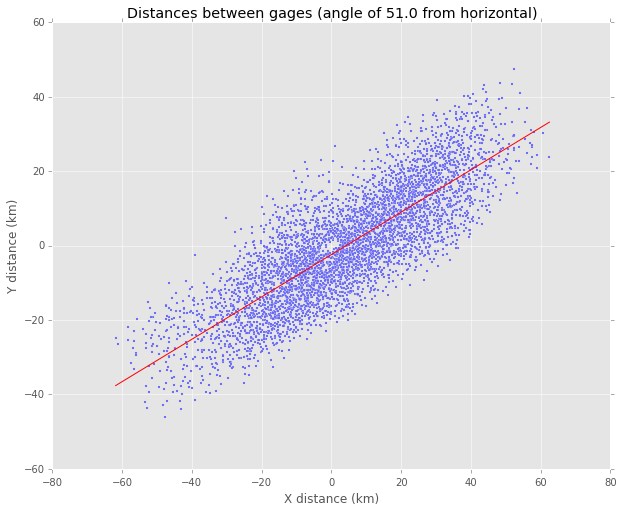

In [5]:
rg.plot_ll()

### Wettest times

For these semi variograms we only allow times in which all the gages record non-zero values. From those select times we pull out the largest accumultations and store them in a **`pandas.DataFrame`** object called **`RainGage.wettest`**. This dataframe is the transpose of earlier dataframes and includes both euclidian and latlon coordinates for each rain gage.  

In [ ]:
rg.get_wettest()

In [ ]:
rg.wettest.head()

You will notice that we have a new SVG_data file saved in our home dir. This was created within the get_wettest function. This file will be used as input to the semivariogram calculation in r. You can set the keyword arguments for the r function by changing the values within the quotes.

In [ ]:
# run r commands to get the SVG
foo = r('SVG_data = read.table("./SVG_data", sep=",",header = TRUE) \n' +
        'source("SVG.r") \n'+
        'SVG_tab <- get_SVG(SVG_data, last_max=TRUE, cressie=TRUE)\n'
        )
df = pd.DataFrame(robjects.numpy2ri.ri2numpy(robjects.globalenv['SVG_tab']))
df.index = df.dist
names=['np', 'dist']
for t in rg.wettest.columns[5::]:
    names.append(t)
df.columns = names

And you can plot the output right here in the notebook:

In [ ]:
df[range(2,len(df.columns))].plot(style='o', figsize=(8, 8), xlim=(1,15), legend=False)
plt.legend(bbox_to_anchor=(1.5, 0.6))
plt.show()

### A particular storm

This operates similarly to the wettest section, but for these semi variograms we are interested in tracking a timespan, such as one particular storm. To this end, we allow times in which some gages record zeros. Again, we pull out the times of interest and store them in a **`pandas.DataFrame`** object called **`RainGage.storm`**. This dataframe is the transpose of earlier dataframes and includes both euclidian and latlon coordinates for each rain gage.  

In [30]:
rad.ll = rg.ll

In [51]:
rad.get_storm('2011-06-26',time_step='1H')

In [55]:
rad.storm.columns

Index([             u'lat',              u'lon',               u'RG',
                      u'Y',                u'X', 2011-06-26 02:00:00,
       2011-06-26 03:00:00, 2011-06-26 04:00:00, 2011-06-26 05:00:00,
       2011-06-26 06:00:00, 2011-06-26 07:00:00, 2011-06-26 08:00:00,
       2011-06-26 09:00:00, 2011-06-26 10:00:00, 2011-06-26 12:00:00,
       2011-06-26 13:00:00, 2011-06-26 14:00:00, 2011-06-26 15:00:00,
       2011-06-26 21:00:00, 2011-06-26 22:00:00, 2011-06-26 23:00:00,
       2011-06-27 00:00:00],
      dtype='object')

Since the number of gages for each time is not consistant, we need to calculate the number of interdistances (np) to make sure that we have about 30 in each bin. So we calculate the semivariogram for each site separately and then aggregate the results

In [56]:
def SVG_storm(rg):
    s = {}
    d = {}
    bar = {}
    for i, col in enumerate(rg.storm):
        if col not in rg.ll.columns:
            foo = r('SVG_data = read.table("./SVG_data", sep=",",header = TRUE) \n' +
                    'source("SVG.r") \n'+
                    'iSVG_tab <- get_iSVG(SVG_data, {index}, target_np=30, alpha=0, tol.hor=90, last_max=FALSE, cressie=FALSE)\n'.format(index=i+1)
                    )
            df = pd.DataFrame(robjects.numpy2ri.ri2numpy(robjects.globalenv['iSVG_tab']))
            try:
                df.index = df.dist
            except:
                continue
            d.update({col: df})
            pdf = df[:]
            pdf.columns = ['np', 'dist', col, 'dir.hor', 'dir.vert', 'id']
            bar.update({col: pdf[col]})
            s.update({col: (df['gamma'].idxmax(axis=0), df['np'].sum())})
    df = pd.DataFrame(s).transpose()
    plotting_df = pd.DataFrame(bar.values()).transpose()
    df.columns=['dist', 'np']
    return plotting_df, df, d

def plot_range(df):
    ax = df['dist'].plot(figsize=(16,6), style='o')
    plt.ylabel('Range distance between gages (km)')
    plt.title('Range distance')
    for i, val in enumerate(df['dist']):
        ax.annotate(s = int(df['np'][i]), xy=(df['dist'].index[i], val))
    plt.show()

In [59]:
pdf, df, d = SVG_storm(rg)

We have access to the raw results by looking inside the **`dictionary`** called **`d`**. This contains all of the variograms with the times at which they occur as the keys. These keys are **`pandas.Timestamp`** objects, so we can call flexibly as shown below. Note that they are not ordered.

In [37]:
d.keys()[0:2]

[Timestamp('2011-06-26 03:00:00'), Timestamp('2011-06-26 02:00:00')]

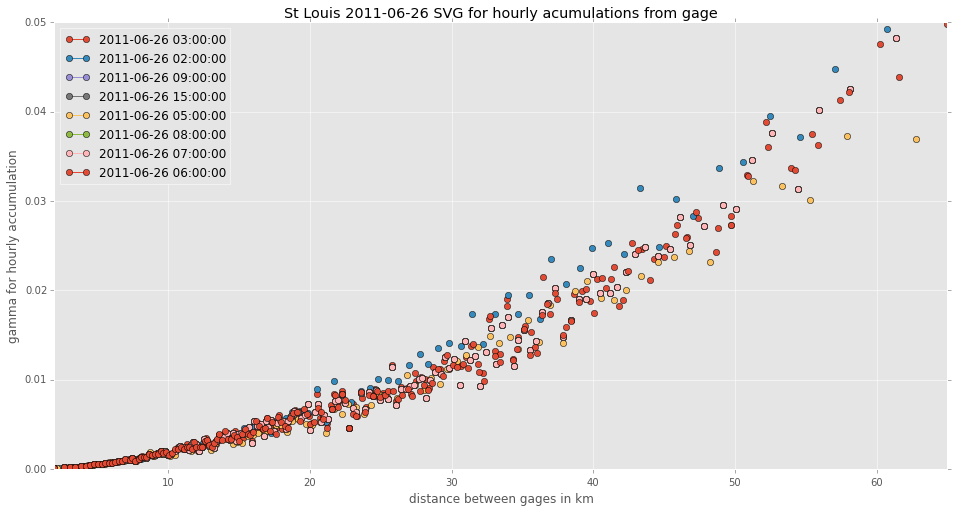

In [60]:
title = 'St Louis 2011-06-26 SVG for hourly acumulations from gage'

pdf.plot(marker = 'o', figsize=(16,8))
plt.ylabel('gamma for hourly accumulation')
plt.xlabel('distance between gages in km')
plt.title(title)
plt.savefig(rg.save_path+'{title}.jpg'.format(title=title))
plt.show()

If we prefer to see the plot of the aggregated results:

In [ ]:
plot_range(df)

### Rainiest Days

This is an attempt to look at the rainiest days using a similar method to that described above. The first step is to select the days.  A straightforward approach is to compute the mean daily rainfall (with a day defined from 12 UTC to 12 UTC to reflect the diurnal cycle of rainfall, especially for the warm season) as the average of all rain gage observations for stations that are active and just rank the days.

In [13]:
rg.get_rainiest_days(4)

In [14]:
rg.rainiest.head()

,lat,lon,RG,Y,X,2009-06-16 12:00:00,2011-06-26 12:00:00,2009-10-09 12:00:00,2010-11-25 12:00:00
RG,,,,,,,,,
RG1,38.70079,-90.22650,RG1,4279.301153,48.710504,2.815167,3.312583,3.005667,3.397250
RG2,38.68573,-90.27758,RG2,4277.635909,42.621495,3.492500,2.042583,3.111500,3.196167
RG3,38.67198,-90.24237,RG3,4276.115517,44.174413,2.476500,4.085167,3.079750,3.683000
RG4,38.65759,-90.20977,RG4,4274.524357,45.432006,2.592917,3.693583,3.132667,3.418417
RG5,38.61467,-90.22187,RG5,4269.778521,39.682676,3.153833,3.164417,2.381250,3.164417


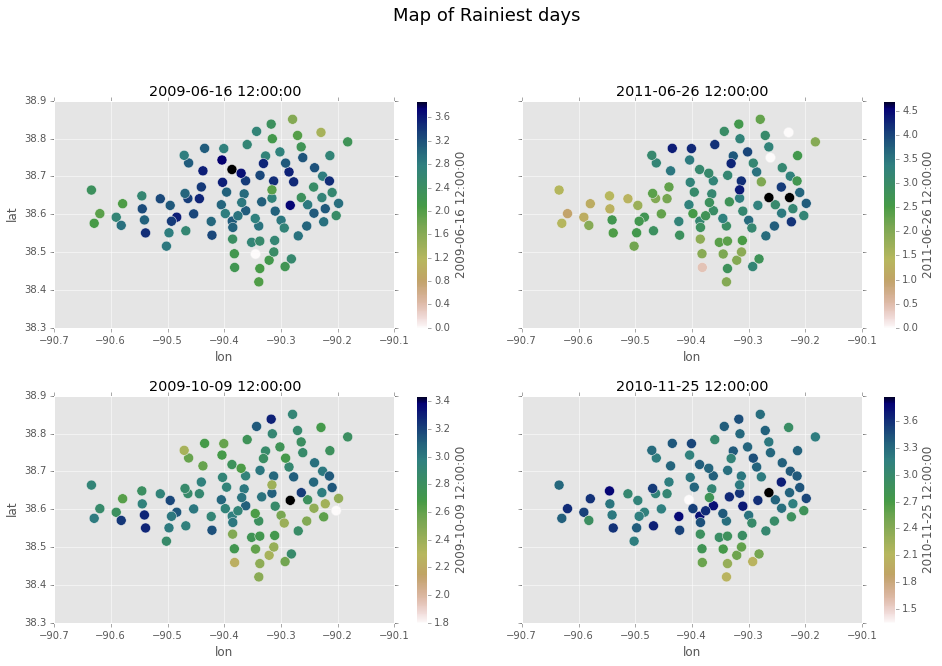

In [16]:
map_rain(rg.rainiest,title= 'Map of Rainiest days', save_path=rg.save_path)

Now we can make a semi variogram of the rainiest days

In [17]:
storm = rg.rainiest[:]
for col in storm:
    if col not in rg.ll.columns:
        storm[col] = storm[col].replace(0, np.nan)
storm.to_csv('SVG_data', index=False)

In [28]:
d = {}
bar = {}
for i, col in enumerate(storm):
    if col not in rg.ll.columns:
        foo = r('SVG_data = read.table("./SVG_data", sep=",",header = TRUE) \n' +
                'source("SVG.r") \n'+
                'iSVG_tab <- get_iSVG(SVG_data, {index}, target_np=5, alpha=39, tol.hor=20, max_bnd=50)\n'.format(index=i+1)
                )
        df = pd.DataFrame(robjects.numpy2ri.ri2numpy(robjects.globalenv['iSVG_tab']))
        try:
            df.index = df.dist
        except:
            continue
        d.update({col: df[:]})
        df.columns = ['np', 'dist', col, 'dir.hor', 'dir.vert', 'id']
        s = df[col]
        bar.update({col: s})
plotting_df = pd.DataFrame(bar.values()).transpose()

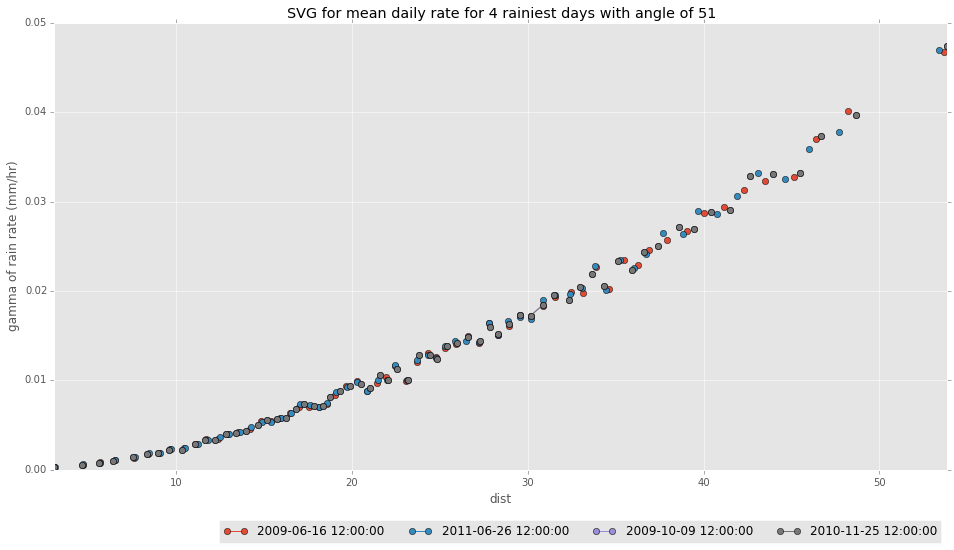

In [29]:
title = 'SVG for mean daily rate for 4 rainiest days with angle of 51'

plotting_df.plot(marker = 'o', figsize=(16,8))
plt.ylabel('gamma of rain rate (mm/hr)'),
plt.legend(bbox_to_anchor=(1, -.1), ncol = 5)
plt.title(title)
plt.savefig(rg.save_path+'{title}.jpg'.format(title=title))
plt.show()